## 6.6 Sourcing & Analyzing Time Series Data

### This script will contain the following:

#### Importing Libraries
#### Importing Data
#### Subsetting, Wrangling & Cleaning Time Series Data
#### Time Series Analysis: Decomposition
#### Testing for Stationarity

# 01. Import Libraries

In [1]:
# Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 02. Import Data

In [2]:
# Path Creation
path = r'/Users/tyrasmussen/Desktop/08-2023 UFC Analysis'

In [3]:
# Import new dataset
data = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'ufc_ppv_buys_dates.csv'))

In [4]:
# Display all results
pd.set_option('display.max_columns', None)

In [5]:
data.head()

,Year,Month,Day,UFC_Number,Opponent1,Opponent2,PPV,Date
0,2001,9,28,33,Ortiz,Matyushenko,75000,2001-9-28
1,2001,11,2,34,Couture,Rizzo,65000,2001-11-2
2,2002,1,11,35,Pulver,Penn,35000,2002-1-11
3,2002,3,22,36,Couture,Barnett,55000,2002-3-22
4,2002,5,10,37,Lindland,Bustamante,50000,2002-5-10


In [6]:
data.shape

(177, 8)

In [7]:
data.columns

Index(['Year', 'Month', 'Day', 'UFC_Number', 'Opponent1', 'Opponent2', 'PPV',
       'Date'],
      dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

# 03. Subsetting, Wrangling & Cleaning Time Series Data

In [9]:
data_sub = data[["Date", "PPV"]]

In [10]:
data_sub.head()

,Date,PPV
0,2001-9-28,75000
1,2001-11-2,65000
2,2002-1-11,35000
3,2002-3-22,55000
4,2002-5-10,50000


In [11]:
data_sub = data_sub.loc[(data_sub['Date'] >= '2010-01-01') & (data_sub['Date'] < '2017-01-01')]

### The data range (2010-01-01 - 2017-01-01) was chosen so the data contains only relavant values (after 2010) and goes up until the most recent date (2017).

In [12]:
data_sub.shape

(95, 2)

In [13]:
data_sub.head()

,Date,PPV
70,2010-1-2,300000
71,2010-2-6,275000
72,2010-2-21,240000
73,2010-3-27,770000
74,2010-4-10,500000


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column
data_sub.head()

,PPV
datetime,
2010-01-02,300000
2010-02-06,275000
2010-02-21,240000
2010-03-27,770000
2010-04-10,500000


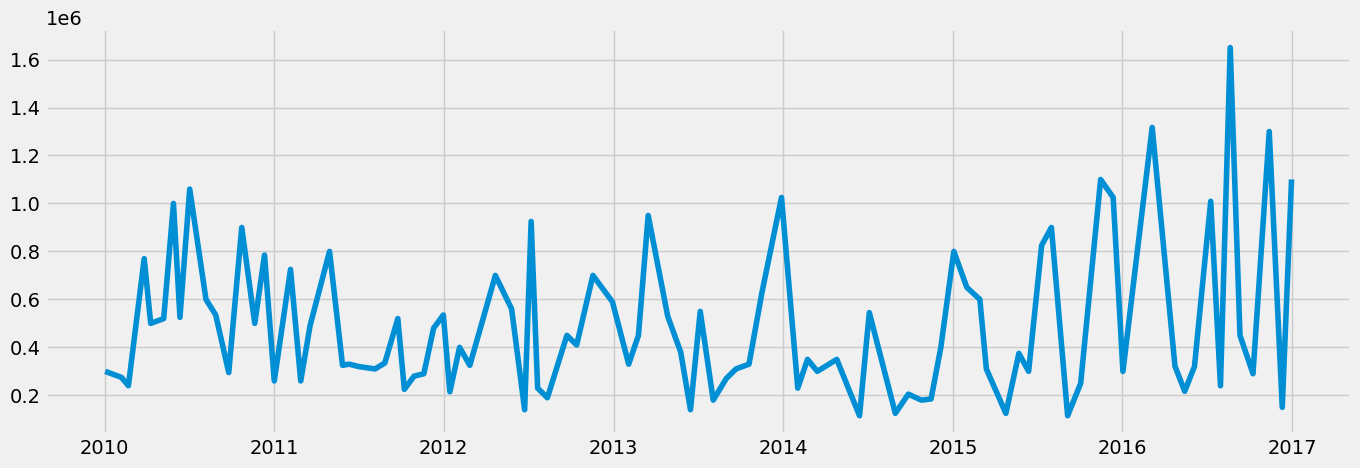

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values
data_sub.isnull().sum()

PPV    0
dtype: int64

In [21]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

31

In [22]:
dups.head()

datetime
2010-01-02    False
2010-02-06    False
2010-02-21    False
2010-03-27    False
2010-04-10    False
dtype: bool

In [23]:
dups = data.duplicated()
dups.sum()

0

# 04. Time Series Analysis: Decomposition

In [24]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = 12)

In [25]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

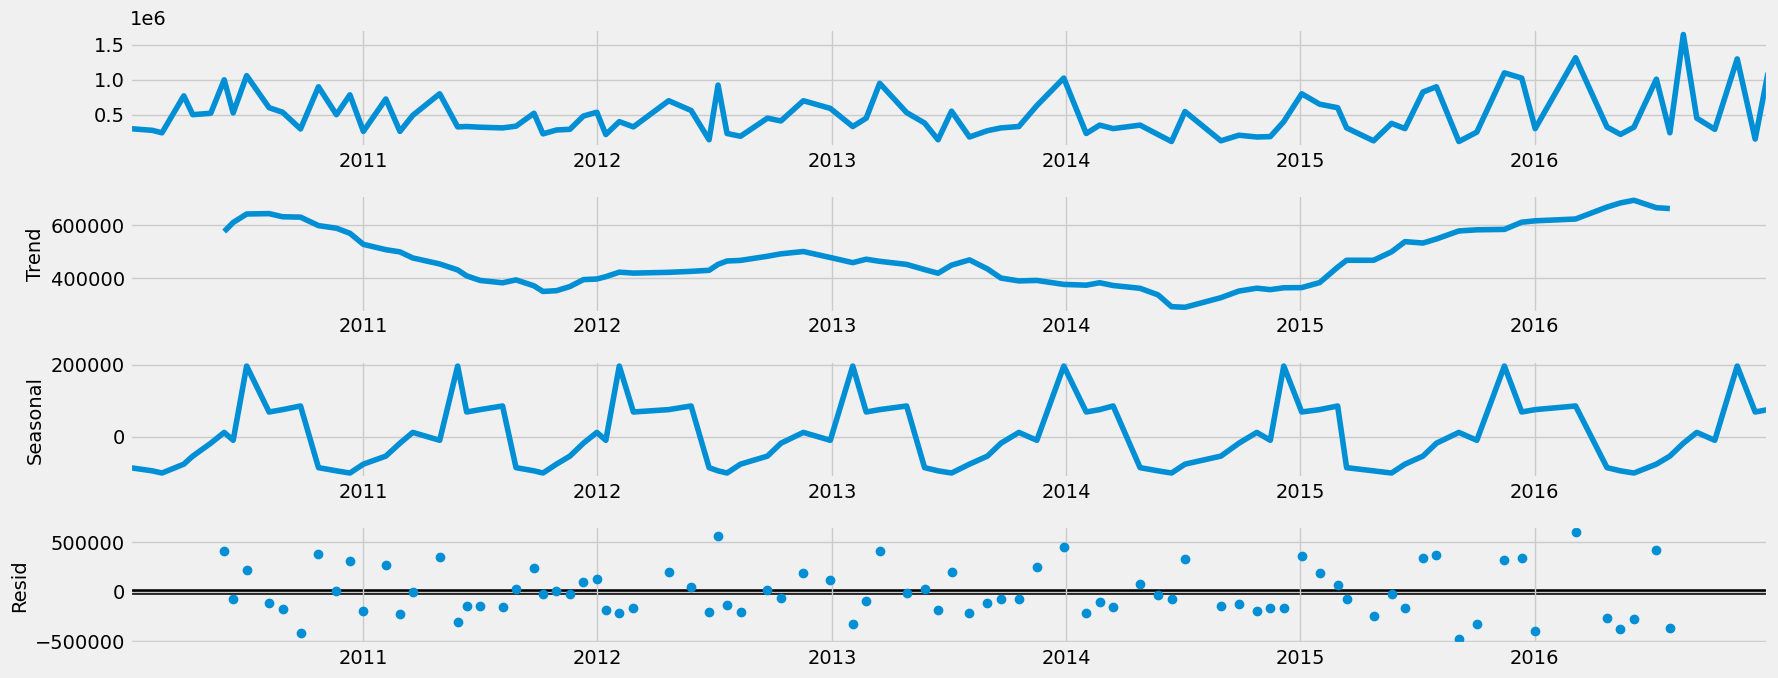

In [26]:
# Plot the separate components

decomposition.plot()
plt.show()

### After separating the components of the time series, we can see negative trends from 2010-2012 and 2013-2014. Also, there are positive trends from 2012-2013 and 2014 to current day. Seasonality does exist within our data as there is a pattern that repeats itself every year with spikes and drops. There is some noise that exists, mostly in recent years.

# 05. Testing for Stationarity

In [27]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['PPV'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.026168e+01
p-value                        4.220557e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


### In order for our null hypothesis (the presence of a unit root) to be proven false, the test statistic must be smaller than the critical value chosen. After conducting the Dickey-Fuller test, the test statistic is smaller than the critical values of 1%, 5% and 10%, (as the test statistic is -1.026168e+01 and the critical value (1%) is -3.501912e+00) meaning we can reject our null hypothesis. This also means that a unit root does not exist and our data is stationary. Also, the p-value is less than 0.05 (4.220557e-18) which indicates that the test result is significant.

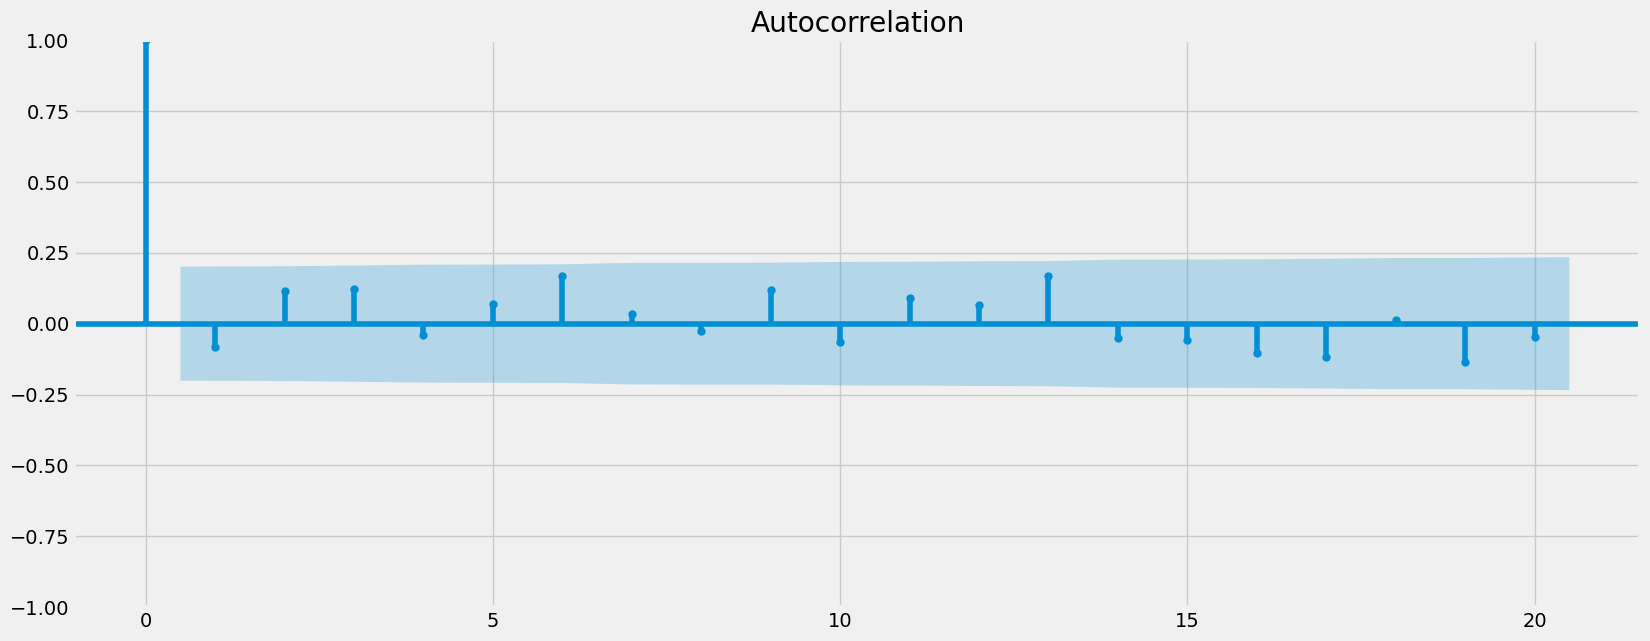

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### There is only one line that goes beyond the confidence interval, which means that there are not lags that are significantly correlated with each other. This further proves that the data is stationary.